In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl, merge_intervals
from utils.colors import qual_cmap
from data_gen_utils.data_gen_my import get_simu_data
from utils.utils import MyDataSet, get_idx_sets
from demo_settings import simu_settings
from CQR import boosting_logi, boosting_pred

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import torch
import scipy.stats as ss
import numpy as np
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict as ddict
from tqdm import tqdm, trange
import random
from joblib import Parallel, delayed
import pandas as pd
from pprint import pprint
from copy import deepcopy
plt.style.use(FIG_ROOT/"base.mplstyle")

# Params

In [5]:
setting = "setting5"

'setting5'

In [6]:
params = edict()

params.simu_setting = edict()
params.simu_setting.rho = 0.9
params.simu_setting.is_homo = False
params.simu_setting.n = 3000
params.simu_setting.d = 10
params.simu_setting.ntest = 1000
params.simu_setting.cal_ratio = 0.25 # for conformal inference
params.simu_setting.val_ratio = 0.15 # for tuning network
params.simu_setting.update(simu_settings[setting])
params.simu_setting.n = 3000
params.simu_setting.d = 10
pprint(params.simu_setting)


params.nrep = 50 # num of reptition for simulation
params.K = 40 # num of sps drawn from q(Y(1)|X)
params.save_snapshot = 100
params.df_dtype = torch.float32
params.device="cpu"
params.n_jobs = 30
params.verbose = True
params.inf_bs = 40 # the inference batch, fct x K


{'cal_ratio': 0.25,
 'd': 10,
 'err_type': 't',
 'is_homo': True,
 'n': 3000,
 'ntest': 1000,
 'rho': 0,
 'val_ratio': 0.15}


In [39]:
from rpy2 import robjects as robj
from CQR import array2d2Robj
r = robj.r
r("""
boosting <- function(Y, X, Xtest, n_trees=100){
    if (class(X)[1] != "data.frame"){
        X <- as.data.frame(X)
        Xtest <- as.data.frame(Xtest)
        names(Xtest) <- names(X)
    }
    data <- data.frame(Y = Y, X)
    fit <- gbm::gbm(Y ~ ., distribution = "bernoulli", data = data, n.trees = n_trees)
    res <- predict(fit, Xtest, type = "response", n.trees = n_trees)
    ress = list()
    ress$fit <- fit
    ress$n_trees <- n_trees
    ress$res <- res
    return(ress)
}
"""
)

r("""
boosting.pred <- function(Xtest, ress){
    if (class(Xtest)[1] != "data.frame"){
        Xtest <- as.data.frame(Xtest)
    }
    res <- predict(ress$fit, Xtest, type = "response", n.trees = ress$n_trees)
    return(res)
}
"""
)
def boosting_logi(Y, X, X_test=None, n_trees=100):
    """
    Perform boosting logistic regression.

    Parameters:
    - Y: The target variable.
    - X: The training data.
    - X_test: The test data.
    - n_trees: The number of trees to use in the boosting algorithm. Default is 100.

    Returns:
    - pred_probs: The predicted probabilities for the test data.
    """
    YR = robj.FloatVector(Y);
    XR = array2d2Robj(X);
    if X_test is None:
        X_test = X
    XtestR = array2d2Robj(X_test);
    ress = r["boosting"](YR, XR, XtestR, n_trees)
    return ress

def boosting_pred(X_test, fit_res):
    """
    Perform pred with results from boosting_logi
    """
    XtestR = array2d2Robj(X_test);
    pred_probs = np.array(r["boosting.pred"](XtestR, fit_res));
    return pred_probs

In [7]:
from sklearn.linear_model import LogisticRegression 

ds = [10, 30, 90, 270, 810, 2400]
maes = []
for d in tqdm(ds):
    data_train = get_simu_data(n=params.simu_setting.n, 
                                 d=d, 
                                 is_homo=params.simu_setting.is_homo, 
                                 rho=params.simu_setting.rho, 
                                 err_type="t");
    data_test = get_simu_data(n=params.simu_setting.n, 
                                 d=d, 
                                 is_homo=params.simu_setting.is_homo, 
                                 rho=params.simu_setting.rho, 
                                 err_type="t");
    clf = LogisticRegression(random_state=0, C=1)
    psY = data_train.T.astype(int)
    psX = data_train.X
    clf = clf.fit(psX, psY);
    def psfun(x):
        if x.ndim == 1:
            x = x.reshape(1, -1)
        return clf.predict_proba(x)[:, 1]
    pred_ps = psfun(data_test.X);
    
    fit_res = boosting_logi(psY, psX, data_test.X);
    pred_ps_boost = boosting_pred(data_test.X, fit_res)
    true_ps = data_test.ps
    err = np.mean(np.abs(pred_ps-true_ps))
    err_boost = np.mean(np.abs(pred_ps_boost-true_ps))
    maes.append([err, err_boost])

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 4/6 [00:02<00:01,  1.35it/s]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 5/6 [00:06<00:01,  1.76s/it]/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP:

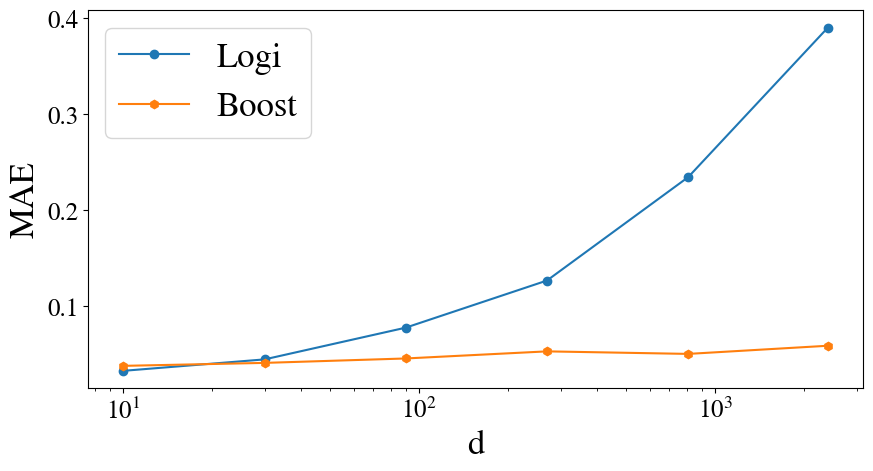

In [8]:
maes = np.array(maes);
plt.plot(ds, maes[:, 0], "o-", label="Logi")
plt.plot(ds, maes[:, 1], "h-", label="Boost")
plt.legend()
plt.xlabel("d")
plt.ylabel("MAE")
plt.xscale("log")

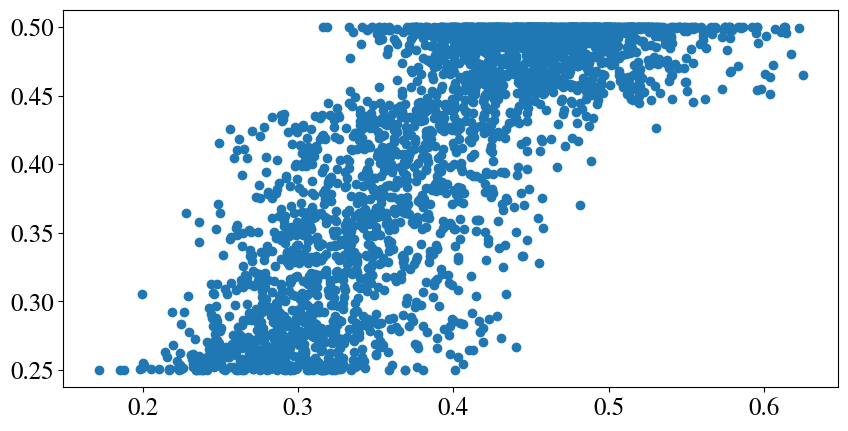

In [9]:
d = 100
data_train = get_simu_data(n=params.simu_setting.n, 
                                 d=d, 
                                 is_homo=params.simu_setting.is_homo, 
                                 rho=params.simu_setting.rho, 
                                 err_type="t");
data_test = get_simu_data(n=params.simu_setting.n, 
                                 d=d, 
                                 is_homo=params.simu_setting.is_homo, 
                                 rho=params.simu_setting.rho, 
                                 err_type="t");
psY = data_train.T.astype(int)
psX = data_train.X
fit_res = boosting_logi(psY, psX);
pred_ps_boost = boosting_pred(data_test.X, fit_res)

plt.plot(pred_ps_boost, data_test.ps, "o")